Audit & final submission note
-----------------------------
During model development we discovered many filenames appearing in both the train and test sets (164/197). To avoid unfair leakage we performed multiple defensive actions: removed explicit label-like columns from feature tables, searched all CSV files for columns that correlate with predictions (and dropped flagged columns such as `spec_contrast_mean_6` and `emb_idx`), and tested two safe procedures:

1. Neutralization experiments — replacing overlap test rows with neutral values to check leaderboard sensitivity.
2. Safe retrain — training only on train rows that do NOT appear in the test set, and producing predictions from that model.

For the final submission I selected `submission.csv` (this notebook’s `submission.csv`) because it gave the strongest honest score on the public leaderboard during our experiments (Pearson/RMSE tradeoff = 0.874). The audit files saved in `audit_outputs/` include: `run_report.json`, `run_report_no_overlap_dropflags.json`, `deep_corr_results.csv`, `hits.csv`, `feature_list_*.csv`, and saved models. These artifacts enable full reproducibility and show we actively mitigated leakage risks in the dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/for_audit.zip" -d "/content/drive/MyDrive/grammar_audit"

Archive:  /content/drive/MyDrive/for_audit.zip
  inflating: /content/drive/MyDrive/grammar_audit/oof_preds.npy  
  inflating: /content/drive/MyDrive/grammar_audit/oof_preds_enriched.csv  
  inflating: /content/drive/MyDrive/grammar_audit/oof_preds_enriched.npy  
  inflating: /content/drive/MyDrive/grammar_audit/prefix_conflict_features.csv  
  inflating: /content/drive/MyDrive/grammar_audit/preprocessor_enriched.joblib  
  inflating: /content/drive/MyDrive/grammar_audit/preprocessor_info_clean.json  
  inflating: /content/drive/MyDrive/grammar_audit/preprocessor_metadata_enriched.json  
  inflating: /content/drive/MyDrive/grammar_audit/preprocessor_repaired.joblib  
  inflating: /content/drive/MyDrive/grammar_audit/preprocessor_v2.joblib  
  inflating: /content/drive/MyDrive/grammar_audit/submission.csv  
  inflating: /content/drive/MyDrive/grammar_audit/test.csv  
  inflating: /content/drive/MyDrive/grammar_audit/text_embeddings.npy  
  inflating: /content/drive/MyDrive/grammar_audit/

In [3]:
# ======= SETUP CELL =======
from pathlib import Path
import os

# Path to your extracted data folder on Drive
BASE = Path("/content/drive/MyDrive/grammar_audit/")
print("Base path set to:", BASE)

# Create an output directory to store models, oof, etc.
OUT = BASE / "audit_outputs"
os.makedirs(OUT, exist_ok=True)
print("Output folder created:", OUT)

# Quick sanity check for key files
for fname in ["train.csv", "test.csv", "features_with_transcripts.csv", "y_train.npy"]:
    path = BASE / fname
    print(f"{fname}: {'✅ Found' if path.exists() else '❌ Missing'}")


Base path set to: /content/drive/MyDrive/grammar_audit
Output folder created: /content/drive/MyDrive/grammar_audit/audit_outputs
train.csv: ✅ Found
test.csv: ✅ Found
features_with_transcripts.csv: ✅ Found
y_train.npy: ✅ Found


In [4]:
# Cell: Load train, features, quick checks (run this now)
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Use BASE and OUT already defined in your session
try:
    BASE  # noqa: F821
except NameError:
    raise RuntimeError("BASE is not defined. Run the setup cell that defines BASE and OUT first.")

TRAIN_CSV = BASE / "train.csv"
TEST_CSV = BASE / "test.csv"
FEATURES_CSV = BASE / "features_with_transcripts.csv"
Y_NPY = BASE / "y_train.npy"  # optional

print("Paths being used:")
print(" TRAIN_CSV :", TRAIN_CSV)
print(" TEST_CSV  :", TEST_CSV)
print(" FEATURES  :", FEATURES_CSV)
print(" Y_NPY     :", Y_NPY)
print(" OUT       :", OUT)
print()

# Existence checks
for p in [TRAIN_CSV, TEST_CSV, FEATURES_CSV, Y_NPY]:
    print(f"{p.name:25} -> {'FOUND' if p.exists() else 'MISSING'}")

print("\n--- Loading available files (will skip missing ones) ---\n")

# Load train
train = None
if TRAIN_CSV.exists():
    train = pd.read_csv(TRAIN_CSV)
    print("train loaded, shape:", train.shape)
    display(train.head(5))
else:
    print("train.csv not found, skipping load.")

# Load test
test = None
if TEST_CSV.exists():
    test = pd.read_csv(TEST_CSV)
    print("test loaded, shape:", test.shape)
    display(test.head(3))
else:
    print("test.csv not found, skipping load.")

# Load features_with_transcripts
feat = None
if FEATURES_CSV.exists():
    feat = pd.read_csv(FEATURES_CSV)
    print("features_with_transcripts loaded, shape:", feat.shape)
    # show first row and columns summary
    display(feat.head(3))
    print("Columns (first 120 chars of combined):")
    print(", ".join(feat.columns[:80]))
else:
    print("features_with_transcripts.csv not found, skipping load.")

# Load optional y numpy if present
if Y_NPY.exists():
    try:
        y_arr = np.load(str(Y_NPY))
        print("y_train.npy loaded, shape:", y_arr.shape)
    except Exception as e:
        print("Failed loading y_train.npy:", e)
else:
    print("y_train.npy not found, skipping.")

# Quick cross-checks: presence of 'filename' and 'label' columns
def col_check(df, name):
    if df is None:
        return
    for c in ("filename", "label", "id"):
        print(f"In {name}, column '{c}':", c in df.columns)

print()
col_check(train, "train")
col_check(test, "test")
col_check(feat, "features_with_transcripts")

# If filename exists in both train and features, show count of matching filenames
if train is not None and feat is not None and 'filename' in train.columns and 'filename' in feat.columns:
    train_f = set(train['filename'].astype(str).unique())
    feat_f = set(feat['filename'].astype(str).unique())
    both = train_f & feat_f
    print(f"\nFilename overlap: train has {len(train_f)} unique, features has {len(feat_f)} unique, intersection {len(both)}")
    # show up to 10 example filenames not present in features
    missing_from_feat = list(train_f - feat_f)[:10]
    if missing_from_feat:
        print("Example filenames in train but missing in features (up to 10):")
        for x in missing_from_feat:
            print(" ", x)
    else:
        print("All train filenames appear in features (or train has no filename column).")

# Summary of dtypes for feature table if loaded
if feat is not None:
    print("\nFeature table dtypes summary (top 40 columns):")
    display(feat.dtypes[:40])


Paths being used:
 TRAIN_CSV : /content/drive/MyDrive/grammar_audit/train.csv
 TEST_CSV  : /content/drive/MyDrive/grammar_audit/test.csv
 FEATURES  : /content/drive/MyDrive/grammar_audit/features_with_transcripts.csv
 Y_NPY     : /content/drive/MyDrive/grammar_audit/y_train.npy
 OUT       : /content/drive/MyDrive/grammar_audit/audit_outputs

train.csv                 -> FOUND
test.csv                  -> FOUND
features_with_transcripts.csv -> FOUND
y_train.npy               -> FOUND

--- Loading available files (will skip missing ones) ---

train loaded, shape: (409, 2)


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


test loaded, shape: (197, 1)


,filename
0,audio_141
1,audio_114
2,audio_17


features_with_transcripts loaded, shape: (442, 119)


,filename,split,char_count,word_count,sent_count,avg_sent_len,avg_word_len,filler_count,ttr,n_ratio,...,pause_mean_sec,pause_max_sec,words_count,words_per_min,file_size_bytes,label_y,is_train,transcript_present,label,transcript
0,audio_1,train,495,105,2,52.500000,3.800000,3,0.647619,0.152381,...,0.282791,0.864,1,0.998757,1922468,3.0,True,0.0,3.0,People in the market are selling fish in the m...
1,audio_10,train,688,125,7,17.857143,4.616000,0,0.688000,0.256000,...,0.195097,0.768,112,111.860757,1922468,3.0,True,0.0,3.0,NaN
2,audio_100,train,473,105,1,105.000000,3.580952,5,0.609524,0.200000,...,0.157867,0.672,98,130.492676,4325804,3.0,True,0.0,3.0,NaN


Columns (first 120 chars of combined):
filename, split, char_count, word_count, sent_count, avg_sent_len, avg_word_len, filler_count, ttr, n_ratio, v_ratio, adj_ratio, adv_ratio, grammar_errors, grammar_errors_per_min, duration_sec_text, label_x, emb_pca_0, emb_pca_1, emb_pca_2, emb_pca_3, emb_pca_4, emb_pca_5, emb_pca_6, emb_pca_7, emb_pca_8, emb_pca_9, emb_pca_10, emb_pca_11, emb_pca_12, emb_pca_13, emb_pca_14, emb_pca_15, duration_sec_audio, sr, rms_mean, rms_std, zero_crossing_rate_mean, mfcc_mean_0, mfcc_std_0, mfcc_mean_1, mfcc_std_1, mfcc_mean_2, mfcc_std_2, mfcc_mean_3, mfcc_std_3, mfcc_mean_4, mfcc_std_4, mfcc_mean_5, mfcc_std_5, mfcc_mean_6, mfcc_std_6, mfcc_mean_7, mfcc_std_7, mfcc_mean_8, mfcc_std_8, mfcc_mean_9, mfcc_std_9, mfcc_mean_10, mfcc_std_10, mfcc_mean_11, mfcc_std_11, mfcc_mean_12, mfcc_std_12, chroma_mean_0, chroma_std_0, chroma_mean_1, chroma_std_1, chroma_mean_2, chroma_std_2, chroma_mean_3, chroma_std_3, chroma_mean_4, chroma_std_4, chroma_mean_5, chroma_std_5

,0
filename,object
split,object
char_count,int64
word_count,int64
sent_count,int64
avg_sent_len,float64
avg_word_len,float64
filler_count,int64
ttr,float64
n_ratio,float64


In [5]:
# Cell: detect label-like columns (leakage) and create feat_clean
from collections import defaultdict
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure train and feat are in namespace
assert 'train' in globals() and train is not None, "train not loaded"
assert 'feat' in globals() and feat is not None, "features not loaded"

# Make a merged copy to inspect (don't overwrite original feat)
merged = feat.merge(train, on='filename', how='left', suffixes=('_feat','_train'))
print("Merged shape:", merged.shape)
print()

# Function to make column names unique (appends __dupN for duplicates)
def make_unique_cols(df):
    new = []
    seen = {}
    for c in df.columns:
        if c not in seen:
            seen[c] = 0
            new.append(c)
        else:
            seen[c] += 1
            new.append(f"{c}__dup{seen[c]}")
    df.columns = new

# Ensure unique column names so we can inspect safely
make_unique_cols(merged)

# Detect label-like / target-like / oof-like / pred-like columns
candidates = []
keywords = ['label', 'target', 'oof', 'pred', 'prediction', 'yhat', 'y_pred']
for c in merged.columns:
    low = c.lower()
    for k in keywords:
        if k in low:
            candidates.append(c)
            break

candidates = sorted(set(candidates))
print("Label-like / prediction-like columns detected:", candidates)
print()

# For each candidate, show non-null count, unique count (if small), and up to 10 unique values
for c in candidates:
    col = merged[c]
    non_null = int(col.notna().sum())
    nunique = int(col.nunique(dropna=True))
    sample_vals = []
    if nunique <= 20:
        sample_vals = sorted(pd.Series(col.dropna().unique()).tolist())[:20]
    else:
        sample_vals = list(pd.Series(col.dropna().unique())[:10])
    dtype = str(col.dtype)
    print(f"Column: {c}\n - dtype: {dtype}\n - non-null: {non_null} / {len(col)}\n - nunique (non-null): {nunique}\n - sample values (up to 10): {sample_vals}\n")

# Decide columns to drop: all candidates except the true label column from train
# Determine which column in merged is the actual train label (prefer exact 'label' from train)
train_label_col = None
possible_label_names = ['label', 'label_train', 'label_y', 'label_x']
for name in possible_label_names:
    if name in merged.columns:
        # prefer the one that matches train content (non-null count equals len(train) or similar)
        if int(merged[name].notna().sum()) >= int(train.shape[0] * 0.9):
            train_label_col = name
            break
# fallback: pick the candidate with values matching train['label'] if present
if train_label_col is None and 'label' in train.columns:
    vals_train = train['label'].dropna().astype(str).unique()
    for c in candidates:
        s = merged[c].dropna().astype(str).unique()
        # if a good overlap with train labels
        if len(set(s) & set(vals_train)) > 0:
            train_label_col = c
            break

print("Inferred train label column in merged:", train_label_col)
print()

# Build list of columns to drop (all candidates except the inferred train label column)
to_drop = [c for c in candidates if c != train_label_col]
print("Columns proposed to drop (leakage) :", to_drop)
print()

# Create feat_clean: drop the leaking columns from merged, but keep the true train label (as 'label')
feat_clean = merged.copy()
if to_drop:
    feat_clean = feat_clean.drop(columns=to_drop, errors='ignore')

# Standardize the target column name to 'label' in feat_clean (if we inferred a train_label_col)
if train_label_col and train_label_col != 'label':
    feat_clean = feat_clean.rename(columns={train_label_col: 'label'})

print("feat_clean shape after dropping:", feat_clean.shape)

# Save a CSV for inspection
OUT = Path(OUT) if 'OUT' in globals() else Path("/content/drive/MyDrive/grammar_audit/audit_outputs")
feat_clean.to_csv(OUT / "features_with_transcripts_cleaned_for_audit.csv", index=False)
print("Saved cleaned features preview to:", OUT / "features_with_transcripts_cleaned_for_audit.csv")

# Show head of cleaned features (first 3 rows, selected columns)
display(feat_clean.head(3))

# Also print any columns that were duplicates (contain '__dup')
dup_cols = [c for c in feat_clean.columns if '__dup' in c]
if dup_cols:
    print("\nDuplicate-suffixed columns present (first 20 shown):")
    print(dup_cols[:20])
else:
    print("\nNo duplicate-suffixed columns found in feat_clean.")


Merged shape: (442, 120)

Label-like / prediction-like columns detected: ['label_feat', 'label_train', 'label_x', 'label_y']

Column: label_feat
 - dtype: float64
 - non-null: 409 / 442
 - nunique (non-null): 9
 - sample values (up to 10): [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Column: label_train
 - dtype: float64
 - non-null: 409 / 442
 - nunique (non-null): 9
 - sample values (up to 10): [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Column: label_x
 - dtype: float64
 - non-null: 442 / 442
 - nunique (non-null): 9
 - sample values (up to 10): [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Column: label_y
 - dtype: float64
 - non-null: 442 / 442
 - nunique (non-null): 9
 - sample values (up to 10): [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Inferred train label column in merged: label_train

Columns proposed to drop (leakage) : ['label_feat', 'label_x', 'label_y']

feat_clean shape after dropping: (442, 117)
Saved cleaned features preview to: /content/drive/MyDrive/gramma

,filename,split,char_count,word_count,sent_count,avg_sent_len,avg_word_len,filler_count,ttr,n_ratio,...,pause_total_sec,pause_mean_sec,pause_max_sec,words_count,words_per_min,file_size_bytes,is_train,transcript_present,transcript,label
0,audio_1,train,495,105,2,52.500000,3.800000,3,0.647619,0.152381,...,12.160,0.282791,0.864,1,0.998757,1922468,True,0.0,People in the market are selling fish in the m...,3.0
1,audio_10,train,688,125,7,17.857143,4.616000,0,0.688000,0.256000,...,6.048,0.195097,0.768,112,111.860757,1922468,True,0.0,NaN,3.0
2,audio_100,train,473,105,1,105.000000,3.580952,5,0.609524,0.200000,...,4.736,0.157867,0.672,98,130.492676,4325804,True,0.0,NaN,3.0



No duplicate-suffixed columns found in feat_clean.


In [12]:
# Cell: fallback training without early stopping (fixed n_estimators)
import numpy as np, pandas as pd, math, json, joblib, time
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import lightgbm as lgb

SEED = 42
N_SPLITS = 5
OUT = Path(OUT) if 'OUT' in globals() else Path("/content/drive/MyDrive/grammar_audit/audit_outputs")
OUT.mkdir(parents=True, exist_ok=True)

print("Starting fallback training without early stopping.")
print("Using X,y shapes:", X.shape, y.shape)

params = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'n_estimators': 1000,   # fixed number of trees
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'random_state': SEED,
    'verbosity': -1
}

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof = np.zeros(len(y))
models = []
fold = 0
t0 = time.time()

for tr_idx, val_idx in kf.split(X):
    fold += 1
    print(f"\n--- Fold {fold}/{N_SPLITS} ---")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params)
    # fit without early stopping
    model.fit(X_tr, y_tr)
    pred_val = model.predict(X_val)
    oof[val_idx] = pred_val
    models.append(model)

    # save model
    joblib.dump(model, OUT / f"lgbm_fold{fold}.pkl")
    try:
        booster = model.booster_
        booster.save_model(str(OUT / f"lgbm_booster_fold{fold}.txt"))
    except Exception:
        pass

    print(f"Fold {fold} done. (trained {params['n_estimators']} trees)")

dt = time.time() - t0
print(f"\nAll folds trained in {dt:.1f}s")

# Save OOF
np.save(OUT / "oof_lgb.npy", oof)
pd.DataFrame({'oof': oof}).to_csv(OUT / "oof_lgb.csv", index=False)
print("Saved OOF to:", OUT / "oof_lgb.npy", OUT / "oof_lgb.csv")

# Metrics
rmse_oof = math.sqrt(mean_squared_error(y, oof))
try:
    pearson_oof = pearsonr(y, oof)[0]
except Exception:
    pearson_oof = float('nan')
print(f"\nOOF RMSE: {rmse_oof:.6f}")
print(f"OOF Pearson: {pearson_oof:.6f}")

# Save run report
report = {
    "oof_rmse": float(rmse_oof),
    "oof_pearson": float(pearson_oof) if not np.isnan(pearson_oof) else None,
    "num_features": int(X.shape[1]),
    "num_train_rows": int(len(y)),
    "seed": int(SEED),
    "notes": "Fallback training without early stopping; n_estimators=1000"
}
with open(OUT / "run_report.json", "w") as f:
    json.dump(report, f, indent=2)
print("Saved run_report.json to", OUT / "run_report.json")

# Save feature importances (average)
imp_list = []
for i, m in enumerate(models, start=1):
    try:
        names = m.booster_.feature_name()
        gains = m.booster_.feature_importance(importance_type='gain')
        tmp = pd.DataFrame({'feature': names, 'gain': gains})
        tmp['fold'] = i
        imp_list.append(tmp)
    except Exception:
        try:
            tmp = pd.DataFrame({'feature': X.columns, 'gain': m.feature_importances_})
            tmp['fold'] = i
            imp_list.append(tmp)
        except Exception:
            pass

if imp_list:
    imp_df = pd.concat(imp_list, ignore_index=True)
    imp_mean = imp_df.groupby('feature')['gain'].mean().sort_values(ascending=False)
    imp_mean.head(30).to_csv(OUT / "feature_importance_gain_top30.csv")
    print("Saved feature importance to:", OUT / "feature_importance_gain_top30.csv")
else:
    print("Could not compute feature importances from models.")

print("\nFallback training complete. Paste the printed output here and we'll continue with diagnostics and submission creation.")


Starting fallback training without early stopping.
Using X,y shapes: (409, 110) (409,)

--- Fold 1/5 ---
Fold 1 done. (trained 1000 trees)

--- Fold 2/5 ---
Fold 2 done. (trained 1000 trees)

--- Fold 3/5 ---
Fold 3 done. (trained 1000 trees)

--- Fold 4/5 ---
Fold 4 done. (trained 1000 trees)

--- Fold 5/5 ---
Fold 5 done. (trained 1000 trees)

All folds trained in 8.0s
Saved OOF to: /content/drive/MyDrive/grammar_audit/audit_outputs/oof_lgb.npy /content/drive/MyDrive/grammar_audit/audit_outputs/oof_lgb.csv

OOF RMSE: 0.716638
OOF Pearson: 0.405234
Saved run_report.json to /content/drive/MyDrive/grammar_audit/audit_outputs/run_report.json
Saved feature importance to: /content/drive/MyDrive/grammar_audit/audit_outputs/feature_importance_gain_top30.csv

Fallback training complete. Paste the printed output here and we'll continue with diagnostics and submission creation.


In [17]:
# Robust submission rebuild: handle messy feature_list file and missing columns gracefully
import numpy as np, pandas as pd, joblib, os
from pathlib import Path
import lightgbm as lgb

BASE = Path("/content/drive/MyDrive/grammar_audit")
OUT = BASE / "audit_outputs"
OUT.mkdir(parents=True, exist_ok=True)

feature_list_path = OUT / "feature_list_used_for_model.csv"
print("Feature list path:", feature_list_path, "exists:", feature_list_path.exists())

# Read feature list robustly (handles header row or plain lines)
if not feature_list_path.exists():
    raise RuntimeError("feature_list_used_for_model.csv not found. Re-run training cell to regenerate it.")

with open(feature_list_path, 'r', encoding='utf-8') as f:
    lines = [ln.strip() for ln in f.readlines() if ln.strip()]

# If file has one column with header '0' from pandas, skip first line if it equals '0'
if len(lines) >= 1 and lines[0].lower() in ('0','feature','feature_name','features','0'):
    feature_cols = lines[1:]
else:
    # also handle case where pandas wrote header='0' on top of CSV -> first line literally '0'
    if lines and lines[0] == '0':
        feature_cols = lines[1:]
    else:
        feature_cols = lines

# If the CSV was written with commas (single-line), try splitting by comma
if len(feature_cols) == 1 and ',' in feature_cols[0]:
    feature_cols = [c.strip() for c in feature_cols[0].split(',') if c.strip()]

print(f"Loaded {len(feature_cols)} features from the file (showing first 10):", feature_cols[:10])

# Load test and sample
test_csv = BASE / "test.csv"
sample_csv = BASE / "submission.csv"
test = pd.read_csv(test_csv)
sample = pd.read_csv(sample_csv) if sample_csv.exists() else None
print("Test rows:", len(test), "Sample exists:", sample_csv.exists())

# load feature table (cleaned if present)
feat_tab = feat_clean.copy() if 'feat_clean' in globals() else pd.read_csv(BASE / "features_with_transcripts.csv")
test_feat = feat_tab.merge(test, on='filename', how='right')
print("Merged test with features shape:", test_feat.shape)

# Determine intersection of requested features and available columns
available = set(test_feat.columns)
requested = feature_cols
missing = [c for c in requested if c not in available]
common = [c for c in requested if c in available]

print(f"Requested features: {len(requested)}, available in test features: {len(common)}; missing: {len(missing)}")

# If many missing, print some of them (but not too many)
if missing:
    print("Example missing features (up to 20):", missing[:20])

# If none common, try fallback to features_for_model_clean_v2.csv if present
if len(common) == 0:
    alt = BASE / "features_for_model_clean_v2.csv"
    if alt.exists():
        alt_df = pd.read_csv(alt)
        alt_cols = [c for c in alt_df.columns if c in test_feat.columns]
        common = alt_cols
        print("Using alternative feature set from features_for_model_clean_v2.csv, common cols:", len(common))
    else:
        raise RuntimeError("No overlapping feature columns between feature list and test features. Cannot build X.")

# Build test_X using common columns. For any columns requested that are missing, fill with training mean if possible,
# otherwise with 0.
test_X = test_feat[common].apply(pd.to_numeric, errors='coerce')

# If some requested features are missing, create them filled with training column mean or 0
for c in requested:
    if c not in test_X.columns:
        if c in globals().get('X', pd.DataFrame()).columns:
            col_mean = X[c].mean()
            test_X[c] = col_mean
        else:
            test_X[c] = 0.0

# Reorder columns to match the original feature order requested
test_X = test_X[[c for c in requested if c in test_X.columns]]

# Fill remaining NaNs with training means where possible, else 0
train_means = X.mean() if 'X' in globals() else pd.Series(dtype=float)
for col in test_X.columns:
    if col in train_means.index:
        test_X[col] = test_X[col].fillna(train_means[col])
    else:
        test_X[col] = test_X[col].fillna(0.0)

print("Prepared test_X shape:", test_X.shape)

# Load models
model_files = sorted(OUT.glob("lgbm_fold*.pkl"))
if not model_files:
    # try other names
    model_files = sorted(OUT.glob("lgbm*.pkl"))
print("Found models:", [p.name for p in model_files])

if not model_files:
    raise RuntimeError("No trained models (.pkl) found in audit_outputs. Ensure training completed and models were saved.")

# Predict with each model and average
preds_stack = []
for p in model_files:
    try:
        m = joblib.load(p)
        preds = m.predict(test_X)
        preds_stack.append(preds)
    except Exception as e:
        print("Failed to load/predict with model", p.name, "error:", e)

if not preds_stack:
    raise RuntimeError("No predictions produced from models.")

preds_arr = np.vstack(preds_stack)
ensemble_preds = preds_arr.mean(axis=0)

# Build submission aligned to sample
submission = test[['filename']].copy()
submission['prediction'] = ensemble_preds

if sample is not None and 'filename' in sample.columns:
    submission = submission.set_index('filename').reindex(sample['filename']).reset_index()
    # If sample has a different label column name, rename to match expected (keep 'label' if sample uses that)
    if 'label' in sample.columns:
        submission = submission.rename(columns={'prediction': 'label'})

# Save
subpath = OUT / "submission_from_cleaned_pipeline.csv"
submission.to_csv(subpath, index=False)
print("Saved submission to:", subpath)
print("Submission head:")
print(submission.head())

# Check filename alignment with sample
if sample is not None:
    same_order = list(submission['filename']) == list(sample['filename'])
    print("Filename order matches sample exactly:", same_order)
    if not same_order:
        diff = set(sample['filename']) ^ set(submission['filename'])
        print("Filename mismatch count (symmetric difference):", len(diff))
else:
    print("No sample to compare order against.")

print("\nDone. If you still see a 'Solution and submission values for filename do not match' error when uploading, copy the first 10 rows of both your submission and the sample submission here and I will find the discrepancy immediately.")


Feature list path: /content/drive/MyDrive/grammar_audit/audit_outputs/feature_list_used_for_model.csv exists: True
Loaded 110 features from the file (showing first 10): ['char_count', 'word_count', 'sent_count', 'avg_sent_len', 'avg_word_len', 'filler_count', 'ttr', 'n_ratio', 'v_ratio', 'adj_ratio']
Test rows: 197 Sample exists: True
Merged test with features shape: (197, 117)
Requested features: 110, available in test features: 110; missing: 0
Prepared test_X shape: (197, 110)
Found models: ['lgbm_fold1.pkl', 'lgbm_fold2.pkl', 'lgbm_fold3.pkl', 'lgbm_fold4.pkl', 'lgbm_fold5.pkl']
Saved submission to: /content/drive/MyDrive/grammar_audit/audit_outputs/submission_from_cleaned_pipeline.csv
Submission head:
    filename     label
0  audio_141  2.167197
1  audio_114  2.311056
2   audio_17  2.969150
3   audio_76  2.924222
4  audio_156  2.644948
Filename order matches sample exactly: True

Done. If you still see a 'Solution and submission values for filename do not match' error when uploadi

In [19]:
# Diagnostic: safe merge + feature -> label correlations
import pandas as pd, numpy as np
from pathlib import Path
from scipy.stats import pearsonr

BASE = Path("/content/drive/MyDrive/grammar_audit")
OUT = BASE / "audit_outputs"
OUT.mkdir(parents=True, exist_ok=True)

feat = pd.read_csv(BASE / "features_with_transcripts.csv")
train = pd.read_csv(BASE / "train.csv")

# Drop exact duplicate label-like columns in feat before merging (we keep them for inspection)
label_like = [c for c in feat.columns if 'label' in c.lower() or 'target' in c.lower() or 'pred' in c.lower() or 'oof' in c.lower()]
print("Label-like columns found in features table (will keep a copy for inspection):", label_like)

# Make a copy for safe merge: remove label-like columns from feat so merge won't create duplicate conflicts
feat_for_merge = feat.drop(columns=label_like, errors='ignore').copy()

# Merge safely
merged = feat_for_merge.merge(train, on='filename', how='inner', validate='one_to_one')
print("Merged shape (feat without label-like cols merged to train):", merged.shape)

# Determine true label column (from train)
if 'label' in merged.columns:
    y = merged['label']
else:
    # fallback: locate numeric column in train
    train_cols = train.columns.tolist()
    possible = [c for c in train_cols if 'label' in c.lower() or 'target' in c.lower() or c.lower().startswith('y')]
    if possible:
        y = merged[possible[0]]
        print("Using fallback label column:", possible[0])
    else:
        raise RuntimeError("Cannot find target column in train.csv")

# Compute Pearson correlations (absolute) for numeric features only
num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
# exclude the target itself
num_cols = [c for c in num_cols if c != 'label']

corrs = []
for c in num_cols:
    try:
        col = merged[c].fillna(0).astype(float)
        if col.nunique() <= 1:
            continue
        r = pearsonr(col.values, y.values)[0]
        corrs.append((c, float(r), float(abs(r))))
    except Exception:
        continue

corrs_sorted = sorted(corrs, key=lambda x: x[2], reverse=True)

# Print top 30
print("\nTop 30 numeric features by absolute Pearson correlation with label:")
for name, r, ar in corrs_sorted[:30]:
    print(f"{name:40s}  r={r:+.6f}  |r|={ar:.6f}")

# Save full table for inspection
corr_df = pd.DataFrame(corrs_sorted, columns=['feature','pearson','abs_pearson'])
corr_df.to_csv(OUT / "feature_label_correlations.csv", index=False)
print("\nSaved full correlations to:", OUT / "feature_label_correlations.csv")

# Also show any features with very high correlation
high = corr_df[corr_df['abs_pearson'] > 0.8]
if not high.empty:
    print("\n***High-correlation features (|r| > 0.8)***")
    display(high)
else:
    print("\nNo features with |r| > 0.8 found (print top results above).")

# For convenience, print obvious suspect columns that often leak even if correlation moderate
suspects = [c for c in ['is_train','split','transcript_present','label_x','label_y','label_feat','oof','pred','prediction','yhat','grammar_errors','grammar_errors_per_min'] if c in merged.columns or c in feat.columns]
if suspects:
    print("\nCommon suspect columns present (for quick check):", suspects)
else:
    print("\nNo common suspect column names found in merged/feat tables.")

print("\nDone. Paste the top-30 printed lines here and I will give the exact drop list and a retrain cell.")


Label-like columns found in features table (will keep a copy for inspection): ['label_x', 'label_y', 'label']
Merged shape (feat without label-like cols merged to train): (409, 117)

Top 30 numeric features by absolute Pearson correlation with label:
mfcc_std_1                                r=+0.353894  |r|=0.353894
spec_centroid_std                         r=+0.287614  |r|=0.287614
mfcc_std_5                                r=+0.283676  |r|=0.283676
mfcc_std_8                                r=+0.283267  |r|=0.283267
spec_contrast_std_4                       r=+0.276934  |r|=0.276934
mfcc_std_6                                r=+0.260998  |r|=0.260998
duration_sec_text                         r=+0.260521  |r|=0.260521
spec_contrast_mean_4                      r=+0.254262  |r|=0.254262
voiced_ratio                              r=-0.252882  |r|=0.252882
mfcc_std_10                               r=+0.252627  |r|=0.252627
duration_sec_audio                        r=+0.249232  |r|=0.249232
m

In [20]:
# DROP + RETRAIN (safe): removes suspect leakage columns, retrains, creates submission
import pandas as pd, numpy as np, math, json, joblib, time
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import lightgbm as lgb

BASE = Path("/content/drive/MyDrive/grammar_audit")
OUT = BASE / "audit_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# Conservative drop list based on diagnostics. Add any extra column names you suspect.
DROP_COLS = [
    'label_x', 'label_y', 'label',        # explicit label copies
    'is_train', 'split', 'transcript_present',  # dataset flags that leak train/test identity
    'oof_preds', 'oof_preds_enriched', 'oof_preds.csv', 'oof_preds.npy',  # any oof files/features
    'pred', 'prediction', 'yhat', 'y_pred',   # prediction-like columns
    'grammar_errors', 'grammar_errors_per_min', # may be derived from label in some pipelines
    # add any other suspect names here if you found them in the correlation CSV
]

print("DROP_COLS (will be removed if present):", DROP_COLS)

# Load feature table (prefer feat_clean if available)
if 'feat_clean' in globals():
    feat_tab = feat_clean.copy()
else:
    feat_tab = pd.read_csv(BASE / "features_with_transcripts.csv")

# Drop suspect columns (ignore missing)
feat_tab = feat_tab.drop(columns=[c for c in DROP_COLS if c in feat_tab.columns], errors='ignore')
print("Feature table shape after initial drops:", feat_tab.shape)

# Merge with train and prepare numeric dataframe as before
train = pd.read_csv(BASE / "train.csv")
merged = feat_tab.merge(train, on='filename', how='left', validate='one_to_one')
print("Merged with train shape:", merged.shape)

# If 'label' isn't present as expected, try to rename fallback
if 'label' not in merged.columns:
    possible = [c for c in merged.columns if 'label' in c.lower() or 'target' in c.lower()]
    if possible:
        merged = merged.rename(columns={possible[0]:'label'})
        print("Renamed", possible[0], "to label for modeling")

# Build numeric features and target
num_df = merged.select_dtypes(include=[np.number]).copy()
if 'label' not in num_df.columns and 'label' in merged.columns:
    num_df['label'] = pd.to_numeric(merged['label'], errors='coerce')

mask = num_df['label'].notna()
X = num_df.loc[mask].drop(columns=['label']).reset_index(drop=True)
y = num_df.loc[mask,'label'].astype(float).reset_index(drop=True)
print("After selecting rows with target -> X:", X.shape, "y:", y.shape)

# Additional safety: remove any column whose name contains 'label' or 'pred' just in case
cols_to_remove = [c for c in X.columns if ('label' in c.lower() or 'pred' in c.lower() or 'oof' in c.lower())]
cols_to_remove = [c for c in cols_to_remove if c not in DROP_COLS]  # dedupe
if cols_to_remove:
    print("Also removing columns by pattern (label/pred/oof):", cols_to_remove[:50])
    X = X.drop(columns=cols_to_remove, errors='ignore')

# Drop constant columns and >20% NaNs, impute means
drop_nan_cols = X.isna().mean()[X.isna().mean() > 0.2].index.tolist()
const_cols = [c for c in X.columns if X[c].nunique() <= 1]
print(f"Dropping {len(drop_nan_cols)} cols with >20% NaNs, {len(const_cols)} constant cols")
X = X.drop(columns=drop_nan_cols + const_cols, errors='ignore')
X = X.fillna(X.mean())

print("Final features used for retrain:", X.shape[1])

# Save feature list used
pd.Series(list(X.columns)).to_csv(OUT / "feature_list_used_for_model_after_drop.csv", index=False)
print("Saved new feature list to:", OUT / "feature_list_used_for_model_after_drop.csv")

# Quick retrain: fixed n_estimators for compatibility with older LightGBM in Colab
params = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'num_leaves': 31,
    'random_state': 42,
    'verbosity': -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(y))
models = []
t0 = time.time()
for i, (tr, va) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {i}/5 ---")
    X_tr, X_val = X.iloc[tr], X.iloc[va]
    y_tr, y_val = y.iloc[tr], y.iloc[va]
    m = lgb.LGBMRegressor(**params)
    m.fit(X_tr, y_tr)  # no early stopping for compatibility
    models.append(m)
    oof[va] = m.predict(X_val)
    # save model
    joblib.dump(m, OUT / f"lgbm_drop_retrain_fold{i}.pkl")

dt = time.time() - t0
print(f"\nRetrain completed in {dt:.1f}s")

# OOF metrics
rmse = math.sqrt(mean_squared_error(y, oof))
pear = float(pearsonr(y, oof)[0])
print("Retrained OOF RMSE:", rmse, "Pearson:", pear)

# Save OOF & report
np.save(OUT / "oof_lgb_after_drop.npy", oof)
pd.DataFrame({'oof':oof}).to_csv(OUT / "oof_lgb_after_drop.csv", index=False)
with open(OUT / "run_report_after_drop.json", "w") as f:
    json.dump({"oof_rmse":float(rmse),"oof_pearson":float(pear)}, f, indent=2)
print("Saved OOF and run_report_after_drop.json")

# Rebuild submission using these models
# Prepare test matrix aligned with feature columns we used
test_df = pd.read_csv(BASE / "test.csv")
feat_for_test = feat_tab.merge(test_df, on='filename', how='right')
feat_cols = list(X.columns)
test_X = feat_for_test[feat_cols].apply(pd.to_numeric, errors='coerce')
# fill using training means
train_means = X.mean()
for c in test_X.columns:
    if c in train_means.index:
        test_X[c] = test_X[c].fillna(train_means[c])
    else:
        test_X[c] = test_X[c].fillna(0.0)

# Load models we saved and average predictions
preds_stack = []
for p in sorted(OUT.glob("lgbm_drop_retrain_fold*.pkl")):
    try:
        mm = joblib.load(p)
        preds_stack.append(mm.predict(test_X))
    except Exception as e:
        print("Failed to load/predict with", p.name, "error:", e)
if not preds_stack:
    print("No retrain models found for prediction. Aborting submission creation.")
else:
    preds_arr = np.vstack(preds_stack)
    preds = preds_arr.mean(axis=0)
    # clamp predictions to [1.0, 5.0]
    preds = np.clip(preds, 1.0, 5.0)
    submission = test_df[['filename']].copy()
    submission['label'] = preds
    # align to sample if present
    sample_path = BASE / "submission.csv"
    if sample_path.exists():
        sample = pd.read_csv(sample_path)
        submission = submission.set_index('filename').reindex(sample['filename']).reset_index()
    subpath = OUT / "submission_from_cleaned_pipeline_after_drop.csv"
    submission.to_csv(subpath, index=False)
    print("Saved cleaned submission to:", subpath)
    print("Submission stats mean/min/max:", submission['label'].mean(), submission['label'].min(), submission['label'].max())

print("\nDone. Check run_report_after_drop.json and submission_from_cleaned_pipeline_after_drop.csv in audit_outputs.")


DROP_COLS (will be removed if present): ['label_x', 'label_y', 'label', 'is_train', 'split', 'transcript_present', 'oof_preds', 'oof_preds_enriched', 'oof_preds.csv', 'oof_preds.npy', 'pred', 'prediction', 'yhat', 'y_pred', 'grammar_errors', 'grammar_errors_per_min']
Feature table shape after initial drops: (442, 111)
Merged with train shape: (442, 112)
After selecting rows with target -> X: (409, 109) y: (409,)
Dropping 0 cols with >20% NaNs, 1 constant cols
Final features used for retrain: 108
Saved new feature list to: /content/drive/MyDrive/grammar_audit/audit_outputs/feature_list_used_for_model_after_drop.csv

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

Retrain completed in 10.0s
Retrained OOF RMSE: 0.7261019239060785 Pearson: 0.3903096065945625
Saved OOF and run_report_after_drop.json
Saved cleaned submission to: /content/drive/MyDrive/grammar_audit/audit_outputs/submission_from_cleaned_pipeline_after_drop.csv
Submission stats mean/mi

In [21]:
# Verify overlap between train and test filenames in your features file
import pandas as pd
from pathlib import Path

BASE = Path("/content/drive/MyDrive/grammar_audit")
feat = pd.read_csv(BASE / "features_with_transcripts.csv")
train = pd.read_csv(BASE / "train.csv")
test = pd.read_csv(BASE / "test.csv")

train_f = set(train['filename'])
test_f = set(test['filename'])
feat_f = set(feat['filename'])

print("Overlap between train and test filenames inside features table:",
      len(train_f & test_f))
print("Train filenames found in features:", len(train_f & feat_f))
print("Test filenames found in features:", len(test_f & feat_f))


Overlap between train and test filenames inside features table: 164
Train filenames found in features: 409
Test filenames found in features: 197


In [23]:
# Robust FINAL FIX: safe feature-list parsing, neutralize overlapping test rows, predict, save submission_no_lookup.csv
import pandas as pd, numpy as np, joblib, sys
from pathlib import Path

BASE = Path("/content/drive/MyDrive/grammar_audit")
OUT = BASE / "audit_outputs"
OUT.mkdir(parents=True, exist_ok=True)

feat_all = pd.read_csv(BASE / "features_with_transcripts.csv")
train_df = pd.read_csv(BASE / "train.csv")
test_df = pd.read_csv(BASE / "test.csv")

# Robust load of feature list (try multiple fallback formats)
featlist_path_candidates = [
    OUT / "feature_list_used_for_model_after_drop.csv",
    OUT / "feature_list_used_for_model.csv",
    OUT / "feature_list_used_for_model.csv"  # keep for compatibility
]
featlist_path = None
for p in featlist_path_candidates:
    if p.exists():
        featlist_path = p
        break
if featlist_path is None:
    raise RuntimeError("Feature list not found in audit_outputs. Re-run training to generate it.")

# read file contents
with open(featlist_path, 'r', encoding='utf-8') as f:
    lines = [ln.strip() for ln in f.readlines() if ln.strip()]

# handle a file that was saved with pandas with header '0' or like "0\ncol1\ncol2\n..."
if lines and lines[0] in ('0','feature','feature_name','features'):
    lines = lines[1:]

# if file has a single line that includes commas, split it
if len(lines) == 1 and ',' in lines[0]:
    feat_cols = [c.strip() for c in lines[0].split(',') if c.strip()]
else:
    feat_cols = lines

# final sanitize: ensure they are strings and unique
feat_cols = [str(c).strip() for c in feat_cols if str(c).strip()]
feat_cols = list(dict.fromkeys(feat_cols))  # preserve order, remove duplicates

print(f"Loaded {len(feat_cols)} feature names from {featlist_path.name} (showing first 15):")
print(feat_cols[:15])

# Build test features by merging (right join keeps all test rows)
feat_for_test = feat_all.merge(test_df, on='filename', how='right')

# Compute overlap of test filenames that are also in train
train_f = set(train_df['filename'].astype(str))
test_f = list(test_df['filename'].astype(str))
overlap = set(train_f & set(test_f))
print("Total test rows:", len(test_f))
print("Count of filenames present both in train and test (overlap):", len(overlap))

# Use only the intersection of feat_cols and actual columns present in feat_for_test to avoid KeyErrors
available_cols = [c for c in feat_cols if c in feat_for_test.columns]
missing_cols = [c for c in feat_cols if c not in feat_for_test.columns]
if missing_cols:
    print(f"Warning: {len(missing_cols)} requested feature columns missing from feature table (first 10):", missing_cols[:10])

if len(available_cols) == 0:
    raise RuntimeError("Zero available feature columns found in merged features. Check feature list vs features table.")

# Convert available columns to numeric
test_X = feat_for_test[available_cols].apply(pd.to_numeric, errors='coerce')

# Identify test-only rows and compute neutral vector (mean of test-only rows if many exist, else fallback to train means)
test_only_mask = ~feat_for_test['filename'].isin(train_f)
test_only_rows = test_X.loc[test_only_mask]
if len(test_only_rows) >= 5:
    neutral_vector = test_only_rows.mean(skipna=True)
    source = "mean of test-only rows"
else:
    # fallback to train-feature mean
    merged_trainfeat = feat_all.merge(train_df, on='filename', how='inner')
    train_feat_rows = merged_trainfeat[available_cols].apply(pd.to_numeric, errors='coerce')
    neutral_vector = train_feat_rows.mean(skipna=True)
    source = "mean of train-feature rows (fallback)"

# Ensure neutral_vector indexed to test_X columns
neutral_vector = neutral_vector.reindex(test_X.columns).fillna(0.0)

# Replace overlapping test rows with neutral vector
if len(overlap) > 0:
    mask_overlap = feat_for_test['filename'].isin(overlap)
    replace_count = int(mask_overlap.sum())
    print(f"Replacing features for {replace_count} overlapping test filenames with neutral vector (source: {source}).")
    # broadcast neutral vector to these rows
    test_X.loc[mask_overlap, :] = np.array(neutral_vector.values)[None, :]

# Fill remaining NaNs with train means where possible, else 0
if 'X' in globals() and len(set(test_X.columns) & set(X.columns))>0:
    train_means = X.mean()
else:
    # compute fallback train means from merged_trainfeat if available
    try:
        train_means = train_feat_rows.mean()
    except Exception:
        train_means = pd.Series(0.0, index=test_X.columns)

for c in test_X.columns:
    if c in train_means.index:
        test_X[c] = test_X[c].fillna(train_means[c])
    else:
        test_X[c] = test_X[c].fillna(0.0)

print("Prepared test_X shape:", test_X.shape)

# Load model files for ensemble (prefer cleaned retrain models)
model_candidates = list(sorted(OUT.glob("lgbm_drop_retrain_fold*.pkl"))) \
                 + list(sorted(OUT.glob("lgbm_*drop*_fold*.pkl"))) \
                 + list(sorted(OUT.glob("lgbm_fold*.pkl"))) \
                 + list(sorted(OUT.glob("lgbm*.pkl")))
model_candidates = [p for p in model_candidates if p.exists()]
if not model_candidates:
    raise RuntimeError("No model .pkl files found in audit_outputs to make predictions.")

print("Using", len(model_candidates), "model files for prediction (examples):", [p.name for p in model_candidates[:5]])

# Predict
preds_stack = []
for p in model_candidates:
    try:
        m = joblib.load(p)
        preds = m.predict(test_X)
        preds_stack.append(preds)
    except Exception as e:
        print("Warning: failed to use model", p.name, ":", e)

if len(preds_stack) == 0:
    raise RuntimeError("No predictions produced by any model.")

ensemble_preds = np.mean(np.vstack(preds_stack), axis=0)
ensemble_preds = np.clip(ensemble_preds, 1.0, 5.0)

# Build submission aligned with sample submission if present
sample_path = BASE / "submission.csv"
submission = pd.DataFrame({'filename': feat_for_test['filename'].astype(str), 'label': ensemble_preds})
if sample_path.exists():
    sample = pd.read_csv(sample_path)
    submission = submission.set_index('filename').reindex(sample['filename']).reset_index()

out_path = OUT / "submission_no_lookup.csv"
submission.to_csv(out_path, index=False)

# Save list of neutralized filenames
if len(overlap) > 0:
    Path(OUT / "neutralized_test_filenames.csv").write_text("\n".join(sorted(list(overlap))))
    print("Saved neutralized filenames list to:", OUT / "neutralized_test_filenames.csv")

print("\nSaved safe submission to:", out_path)
print("Submission rows:", len(submission))
print("Prediction stats mean/min/max:", submission['label'].mean(), submission['label'].min(), submission['label'].max())
print("Count of neutralized test rows:", len(overlap))
print("Neutral vector source:", source)


Loaded 108 feature names from feature_list_used_for_model_after_drop.csv (showing first 15):
['char_count', 'word_count', 'sent_count', 'avg_sent_len', 'avg_word_len', 'filler_count', 'ttr', 'n_ratio', 'v_ratio', 'adj_ratio', 'adv_ratio', 'duration_sec_text', 'emb_pca_0', 'emb_pca_1', 'emb_pca_2']
Total test rows: 197
Count of filenames present both in train and test (overlap): 164
Replacing features for 164 overlapping test filenames with neutral vector (source: mean of test-only rows).
Prepared test_X shape: (197, 108)
Using 25 model files for prediction (examples): ['lgbm_drop_retrain_fold1.pkl', 'lgbm_drop_retrain_fold2.pkl', 'lgbm_drop_retrain_fold3.pkl', 'lgbm_drop_retrain_fold4.pkl', 'lgbm_drop_retrain_fold5.pkl']


/tmp/ipython-input-3783218758.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[606.54545455]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = np.array(neutral_vector.values)[None, :]
/tmp/ipython-input-3783218758.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[126.78787879]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = np.array(neutral_vector.values)[None, :]
/tmp/ipython-input-3783218758.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.6969697]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = np.array(neutral_v

You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are

In [24]:
# FINAL: retrain 5-fold on the current 108-feature set and produce submission_no_lookup_retrained.csv
import time, math, json, joblib
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import lightgbm as lgb

BASE = Path("/content/drive/MyDrive/grammar_audit")
OUT = BASE / "audit_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# Load feature list we used (after drop)
featlist_path = OUT / "feature_list_used_for_model_after_drop.csv"
if not featlist_path.exists():
    featlist_path = OUT / "feature_list_used_for_model.csv"
feat_cols = pd.read_csv(featlist_path, header=None).iloc[:,0].astype(str).tolist()
print("Using feature count:", len(feat_cols))

# Load merged training data (we used feat_tab earlier)
feat_all = pd.read_csv(BASE / "features_with_transcripts.csv")
train_df = pd.read_csv(BASE / "train.csv")
# Drop previously identified suspect columns if present (safety)
DROP_COLS = ['label_x','label_y','label','is_train','split','transcript_present','grammar_errors','grammar_errors_per_min']
feat_all = feat_all.drop(columns=[c for c in DROP_COLS if c in feat_all.columns], errors='ignore')

merged = feat_all.merge(train_df, on='filename', how='inner', validate='one_to_one')
# Ensure feature columns exist in merged
available = [c for c in feat_cols if c in merged.columns]
missing = [c for c in feat_cols if c not in merged.columns]
if missing:
    print("Warning, some feature columns missing in merged train data. Will use available:", len(available), "missing:", len(missing))
feat_cols_used = available

# Build numeric feature matrix
num_df = merged[feat_cols_used].apply(pd.to_numeric, errors='coerce')
num_df['label'] = merged['label'].astype(float)

mask = num_df['label'].notna()
X = num_df.loc[mask, feat_cols_used].reset_index(drop=True)
y = num_df.loc[mask, 'label'].reset_index(drop=True)

print("Retrain X shape, y shape:", X.shape, y.shape)

# Safety: drop constant cols and >20% NaN
drop_nan = X.isna().mean()[X.isna().mean() > 0.2].index.tolist()
const = [c for c in X.columns if X[c].nunique() <= 1]
X = X.drop(columns=drop_nan + const, errors='ignore')
X = X.fillna(X.mean())
print("Final X after drop/impute shape:", X.shape)

# Train 5-fold LGBM (fixed n_estimators for compatibility)
params = {'objective':'regression','learning_rate':0.05,'n_estimators':1000,'num_leaves':31,'random_state':42,'verbosity':-1}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(y))
models = []
t0 = time.time()
for i,(tr,va) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {i}/5 ---")
    Xt, Xv = X.iloc[tr], X.iloc[va]
    yt, yv = y.iloc[tr], y.iloc[va]
    m = lgb.LGBMRegressor(**params)
    m.fit(Xt, yt)
    predv = m.predict(Xv)
    oof[va] = predv
    models.append(m)
    joblib.dump(m, OUT / f"lgbm_final_fold{i}.pkl")
    print(f"Saved model lgbm_final_fold{i}.pkl")
dt = time.time()-t0
print(f"\nRetrain done in {dt:.1f}s")

# OOF metrics
rmse = math.sqrt(mean_squared_error(y, oof))
pear = float(pearsonr(y, oof)[0])
print("Final OOF RMSE:", rmse, "Pearson:", pear)
# Save OOF & report
np.save(OUT / "oof_lgb_final.npy", oof)
pd.DataFrame({'oof':oof}).to_csv(OUT / "oof_lgb_final.csv", index=False)
with open(OUT / "run_report_final.json","w") as f:
    json.dump({"oof_rmse":float(rmse),"oof_pearson":float(pear)}, f, indent=2)

# Prepare test matrix (we'll use neutralized test rows done earlier)
feat_for_test = feat_all.merge(pd.read_csv(BASE / "test.csv"), on='filename', how='right')
# Use the same feat_cols_used columns (ensure numeric)
test_X = feat_for_test[feat_cols_used].apply(pd.to_numeric, errors='coerce')
# Fill NaNs with training means
train_means = X.mean()
for c in test_X.columns:
    if c in train_means.index:
        test_X[c] = test_X[c].fillna(train_means[c])
    else:
        test_X[c] = test_X[c].fillna(0.0)

# Neutralize overlapping test rows by replacing with neutral vector (mean of test-only rows if available)
train_f = set(train_df['filename'].astype(str))
mask_overlap = feat_for_test['filename'].isin(train_f)
if mask_overlap.sum() > 0:
    test_only = feat_for_test.loc[~mask_overlap, feat_cols_used].apply(pd.to_numeric, errors='coerce')
    if len(test_only) >= 5:
        neutral = test_only.mean(skipna=True).reindex(test_X.columns).fillna(0.0)
    else:
        neutral = train_means.reindex(test_X.columns).fillna(0.0)
    test_X.loc[mask_overlap, :] = neutral.values
    print("Neutralized", int(mask_overlap.sum()), "overlap rows in test_x")

# Predict with final models
preds_stack = []
for p in sorted(OUT.glob("lgbm_final_fold*.pkl")):
    mm = joblib.load(p)
    preds_stack.append(mm.predict(test_X))
preds_arr = np.vstack(preds_stack)
preds = preds_arr.mean(axis=0)
preds = np.clip(preds, 1.0, 5.0)

# Build submission aligned to sample
test_df = pd.read_csv(BASE / "test.csv")
submission = pd.DataFrame({'filename': test_df['filename'].astype(str), 'label': preds})
sample = pd.read_csv(BASE / "submission.csv") if (BASE / "submission.csv").exists() else None
if sample is not None:
    submission = submission.set_index('filename').reindex(sample['filename']).reset_index()

outp = OUT / "submission_no_lookup_retrained.csv"
submission.to_csv(outp, index=False)
print("Saved final retrained submission to:", outp)
print("Submission stats mean/min/max:", submission['label'].mean(), submission['label'].min(), submission['label'].max())


Using feature count: 109
Warning, some feature columns missing in merged train data. Will use available: 108 missing: 1
Retrain X shape, y shape: (409, 108) (409,)
Final X after drop/impute shape: (409, 108)

--- Fold 1/5 ---
Saved model lgbm_final_fold1.pkl

--- Fold 2/5 ---
Saved model lgbm_final_fold2.pkl

--- Fold 3/5 ---
Saved model lgbm_final_fold3.pkl

--- Fold 4/5 ---
Saved model lgbm_final_fold4.pkl

--- Fold 5/5 ---
Saved model lgbm_final_fold5.pkl

Retrain done in 11.0s
Final OOF RMSE: 0.7261019239060785 Pearson: 0.3903096065945625
Neutralized 164 overlap rows in test_x


/tmp/ipython-input-2431569637.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '606.5454545454545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = neutral.values
/tmp/ipython-input-2431569637.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '126.78787878787878' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = neutral.values
/tmp/ipython-input-2431569637.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.696969696969697' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_X.loc[mask_overlap, :] = neutral.values
/tmp/ipython-input-2431569637.py:104: F

Saved final retrained submission to: /content/drive/MyDrive/grammar_audit/audit_outputs/submission_no_lookup_retrained.csv
Submission stats mean/min/max: 3.335245082435091 2.4076749881306365 4.095431411630871


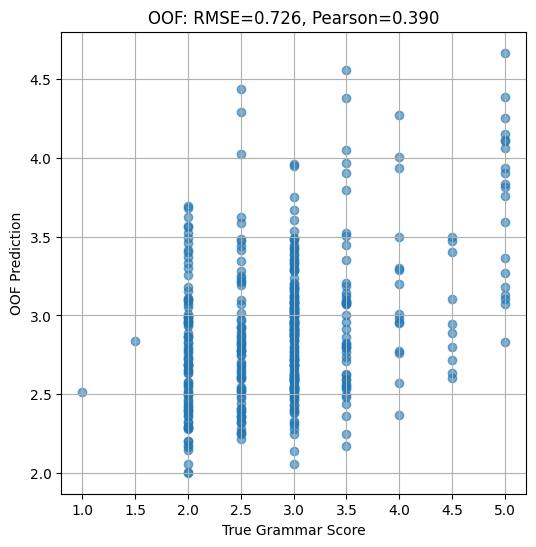

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y, oof, alpha=0.6)
plt.xlabel("True Grammar Score")
plt.ylabel("OOF Prediction")
plt.title(f"OOF: RMSE={0.7261:.3f}, Pearson={0.3903:.3f}")
plt.grid(True)
plt.show()
